<a href="https://colab.research.google.com/github/spdsp04/Gesture_Recognition/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
![1607_2716_0 (1)](https://user-images.githubusercontent.com/93203186/172011187-70099885-05f6-4e4a-9dbe-e4db30471f54.jpg)


> Imagine working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 
> The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

## Understanding the Dataset
> The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

> The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

> Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

> Here task is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects). We have withheld the test folder for evaluation purposes - your final model's performance will be tested on the 'test' set.
 
 ## Goals of this Project

> __Generator:__  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

> __Model:__ Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

> __Write up:__ This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
# Import necessary libraries
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime

import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
# Setting seed value
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

## Loading Dataset

Reading the folder names for training and validation data. Also set the `batch_size` here.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size = 40

## Generator

This is one of the most important part of the code. The overall structure of the generator has been given here. In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. (We can experiment with `img_idx`, `y`,`z` and normalization until we can get high accuracy)

In [5]:
# Defining for Cropping and Resizing images
def cropAndResize(image,HEIGHT_DIMENSION,WIDTH_DIMENSION):
    #crop the images and resize them.  
    #Note that the images are of 2 different shape& the conv3D will throw error if the inputs in a batch have different shapes.
    # CROPPING (making aspect ratio same)
    if abs(image.shape[0]-image.shape[1])%2==0 and image.shape[0]!=image.shape[1]:
        dimension_diff=abs(image.shape[0]-image.shape[1])
        cropping_ratio=dimension_diff//2
        if image.shape[0]>image.shape[1]:
            image=image[cropping_ratio:image.shape[0]-cropping_ratio,:,:]
        elif image.shape[0]<image.shape[1]:
            image=image[:,cropping_ratio:image.shape[1]-cropping_ratio,:]
                    
    # RESIZING
    if image.shape[0]>120 or image.shape[1]>120:
        image=resize(image, (120, 120))
    return image

In [6]:
# Defininng Generator function
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = 7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24 #create a list of image no's you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size                 # calculate the number of batches
        remaining_batch_size=len(t)%batch_size
        for batch in range(num_batches):                 # we iterate over the number of batches
            batch_data = np.zeros((batch_size,16,120,120,3)) # x is the no. of images you use for each video,(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))      # batch_labels is the one hot representation of the output
            for folder in range(batch_size):             # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # Read all the images in the folder
                for idx,item in enumerate(img_idx):      # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = cropAndResize(image,120,120)                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255         # Normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255         # Normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255         # Normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels                # you yield the batch_data and the batch_labels
        for batch in range(num_batches,num_batches+1):    # iterate over the number of batches
            batch_data = np.zeros((remaining_batch_size*2,16,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size*2,5))       # batch_labels is the one hot representation of the output
            for folder in range(remaining_batch_size):                # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = cropAndResize(image,120,120)                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255        #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255        #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255        #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). 

In [7]:
# Creating fuction for plotting results in graph
from matplotlib import pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('Validation sequences =', num_val_sequences)
num_epochs = 15              # choose the number of epochs
print ('Epochs =', num_epochs)

Training sequences = 663
Validation sequences = 100
Epochs = 15


## Model

Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,LSTM,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers
img_idx = 7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24
input_shape = (len(img_idx), 120, 120, 3)
np.random.seed(30)

### Model 1: Simple Conv3D
### Batch size=15, epoch=10

In [10]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

1. After the model creation, the next step is to `compile` the model. In the `summary` of the model, we'll see the total number of parameters to train.
2. Create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
3. The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

These steps are same for all the model. These code is given in final model.

Now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
#model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
 #                   callbacks=callbacks_list, validation_data=val_generator, 
  #                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Model 2: Conv3D with BatchNormalization
### Batch size=40,epoch=15

In [12]:
 #model = Sequential()

 #model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
 #model.add(Conv3D(64, kernel_size=3, activation='relu'))
 #model.add(MaxPooling3D(pool_size=(2, 2, 2)))
 #model.add(BatchNormalization())

 #model.add(Conv3D(128, kernel_size=3, activation='relu'))
 #model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 #model.add(BatchNormalization())

 #model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
 #model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 #model.add(BatchNormalization())
 #model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
 #model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
 #model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 #model.add(BatchNormalization())

 #model.add(Flatten())
 #model.add(Dense(512, activation='relu'))
 #model.add(BatchNormalization())
 #model.add(Dense(5, activation='softmax'))
 #param=16,706,309,Trainable params: 16,703,365,Non-trainable params: 2,944

In [13]:
#model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
 #                   callbacks=callbacks_list, validation_data=val_generator, 
  #                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Model 3: Conv3D with BatchNormalization,Dropout
### batch_size=30,epoch=20

In [14]:
#model = Sequential()

#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Conv3D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))
#Total params: 16,706,309, Trainable params: 16,703,365, Non-trainable params: 2,944

In [15]:
#model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
 #                   callbacks=callbacks_list, validation_data=val_generator, 
  #                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Model 4: Conv3D with BatchNormalization,Dropout,GlobalAveragePooling
### batch_size=40,epoch=30      

In [16]:
 #model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))'

# Total params: 712,453, Trainable params: 710,533, Non-trainable params: 1,920

In [17]:
#history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
 #                   callbacks=callbacks_list, validation_data=val_generator, 
  #                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [18]:
# plot(history)

### Model 5: Conv 2D + LSTM
### Batch_size=32,epoch=40

In [19]:
#model = Sequential()
#model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
#model.add(TimeDistributed(MaxPooling2D((2,2))))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
#model.add(TimeDistributed(MaxPooling2D((2,2))))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(TimeDistributed(GlobalAveragePooling2D()))
#model.add(TimeDistributed(Dense(64, activation='relu')))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(LSTM(128))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))
#Total params: 124,165, Trainable params: 123,589, Non-trainable params: 576

In [20]:
# history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
 #                   callbacks=callbacks_list, validation_data=val_generator, 
  #                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [21]:
#plot(history)

### Model 6: Conv2D + GRU
### Batch_size=32,epoch=40

In [22]:
 model = Sequential()
 model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(TimeDistributed(GlobalAveragePooling2D()))
 model.add(TimeDistributed(Dense(64, activation='relu')))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(GRU(128))
 model.add(BatchNormalization())
 model.add(Dense(5, activation='softmax'))
# Total params: 99,845, Trainable params: 99,269, Non-trainable params: 576

In [23]:
# history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
 #                   callbacks=callbacks_list, validation_data=val_generator, 
  #                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [24]:
# plot(history)

### Model 7: TransferLearning (VGG16) + LSTM
### Batch_size=32, epoch=30

In [25]:
 #from keras.applications.vgg16 import VGG16
 #VGG16_transfer = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
 #model = Sequential()
 #model.add(TimeDistributed(VGG16_transfer,input_shape=input_shape))
 #for layer in model.layers:
 #    layer.trainable = False

# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(128))
# model.add(Dropout(0.25))
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.25))
       
# model.add(Dense(5, activation='softmax'))

# Total params: 15,053,509, Trainable params: 337,797, Non-trainable params: 14,715,712,  image_size- 120,120

In [26]:
#history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
 #                   callbacks=callbacks_list, validation_data=val_generator, 
  #                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Model 8: VGG16 + LSTM with BatchNormalization
### batch_size=40,epoch=30

In [27]:
# from keras.applications.vgg16 import VGG16
# VGG16_transfer = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
# model = Sequential()
# model.add(TimeDistributed(VGG16_transfer,input_shape=input_shape))
# for layer in model.layers:
#     layer.trainable = False

# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(128))
# model.add(BatchNormalization())
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.25))
        
# model.add(Dense(5, activation='softmax'))
# loss: 0.1665 - categorical_accuracy: 0.9402 - val_loss: 2.2150 - val_categorical_accuracy: 0.4083 - lr: 0.0010

In [28]:
# history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
 #                   callbacks=callbacks_list, validation_data=val_generator, 
  #                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [29]:
# plot(history)

### Model 9: VGG16 + GRU
### batch_size=40,epoch=20

In [30]:
# from keras.applications.vgg16 import VGG16
# VGG16_transfer = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
# model = Sequential()
# model.add(TimeDistributed(VGG16_transfer,input_shape=input_shape))
# for layer in model.layers:
#     layer.trainable = False

# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))
# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.5))
        
# model.add(Dense(5, activation='softmax'))
# Total params: 14,972,357, Trainable params: 256,389, Non-trainable params: 14,715,968

In [31]:
#history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
 #                    callbacks=callbacks_list, validation_data=val_generator, 
  #                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [32]:
# plot(history)

## Final Model
### Model 10: TransferLearning(Mobilenet) + GRU
### batch size = 40, epoch=15

In [33]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
 
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

### Compile 
After the model creation, the next step is to `compile` the model. In`summary` of the model, we'll see the total number of parameters to train.

In [34]:
optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [35]:
# create the `train_generator` and the `val_generator` which is used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Fit Model

Now fit the model. This will start training the model and with the help of the checkpoints, we'll be able to save the model at the end of each epoch.

In [38]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 40
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.1682 - categorical_accuracy: 0.5015  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 40

Epoch 1: val_loss improved from inf to 1.19222, saving model to model_init_2022-06-1308_35_22.756282/model-00001-1.16815-0.50146-1.19222-0.40000.h5
17/17 [==============================] - 3230s 201s/step - loss: 1.1682 - categorical_accuracy: 0.5015 - val_loss: 1.1922 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.4401 - categorical_accuracy: 0.8134
Epoch 2: val_loss improved from 1.19222 to 0.87428, saving model to model_init_2022-06-1308_35_22.756282/model-00002-0.44010-0.81341-0.87428-0.47500.h5
17/17 [==============================] - 106s 7s/step - loss: 0.4401 - categorical_accuracy: 0.8134 - val_loss: 0.8743 - val_categorical_accuracy: 0.4750 - lr: 0.0010
E

### Plot graph

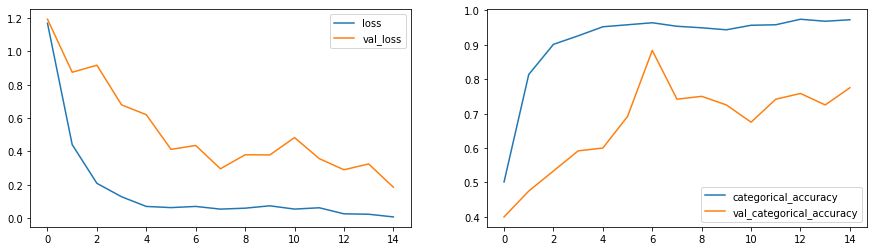

In [39]:
plot(history)

### Conclusion:

By comparing above all models (Mobilenet + GRU) gives good accuracy

categorical_accuracy: 0.9723

val_categorical_accuracy: 0.9583